# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import acf, pacf
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, r2_score, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn.multioutput import MultiOutputRegressor
from scipy.stats import randint
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# Importing Files

In [2]:
train = pd.read_csv('../data/train.csv')
labels = pd.read_csv('../data/train_labels.csv')
pairs = pd.read_csv('../data/target_pairs.csv')

In [3]:
train.shape, labels.shape, pairs.shape

((1961, 558), (1961, 425), (424, 3))

In [4]:
train.head()

,date_id,LME_AH_Close,LME_CA_Close,LME_PB_Close,LME_ZS_Close,JPX_Gold_Mini_Futures_Open,JPX_Gold_Rolling-Spot_Futures_Open,JPX_Gold_Standard_Futures_Open,JPX_Platinum_Mini_Futures_Open,JPX_Platinum_Standard_Futures_Open,...,FX_GBPCAD,FX_CADCHF,FX_NZDCAD,FX_NZDCHF,FX_ZAREUR,FX_NOKGBP,FX_NOKCHF,FX_ZARCHF,FX_NOKJPY,FX_ZARGBP
0,0,2264.5,7205.0,2570.0,3349.0,NaN,NaN,NaN,NaN,NaN,...,1.699987,0.776874,0.888115,0.689954,0.066653,0.090582,0.119630,0.078135,13.822740,0.059163
1,1,2228.0,7147.0,2579.0,3327.0,NaN,NaN,NaN,NaN,NaN,...,1.695279,0.778682,0.889488,0.692628,0.067354,0.091297,0.120520,0.079066,13.888146,0.059895
2,2,2250.0,7188.5,2587.0,3362.0,4684.0,4691.0,4684.0,3363.0,3367.0,...,1.692724,0.780186,0.894004,0.697490,0.067394,0.091478,0.120809,0.079287,13.983675,0.060037
3,3,2202.5,7121.0,2540.0,3354.0,4728.0,4737.0,4729.0,3430.0,3426.0,...,1.683111,0.785329,0.889439,0.698502,0.067639,0.091558,0.121021,0.079285,14.035571,0.059983
4,4,2175.0,7125.0,2604.0,3386.0,NaN,NaN,NaN,NaN,NaN,...,1.684816,0.787264,0.891042,0.701485,0.067443,0.091266,0.121055,0.078925,14.013760,0.059503


In [5]:
labels.head()

,date_id,target_0,target_1,target_2,target_3,target_4,target_5,target_6,target_7,target_8,...,target_414,target_415,target_416,target_417,target_418,target_419,target_420,target_421,target_422,target_423
0,0,0.005948,-0.002851,-0.004675,-0.000639,NaN,NaN,-0.006729,0.006066,NaN,...,NaN,0.021239,-0.005595,NaN,-0.004628,0.033793,NaN,0.038234,NaN,0.027310
1,1,0.005783,-0.024118,-0.007052,-0.018955,-0.031852,-0.019452,0.003002,-0.006876,-0.002042,...,0.003377,0.021372,-0.001517,0.012846,0.010547,0.030527,-0.000764,0.025021,0.003548,0.020940
2,2,0.001048,0.023836,-0.008934,-0.022060,NaN,NaN,0.037449,0.007658,NaN,...,-0.006712,0.009308,0.001857,-0.012761,-0.002345,0.017529,-0.005394,0.004835,-0.009075,0.001706
3,3,0.001700,-0.024618,0.011943,0.004778,NaN,NaN,-0.012519,-0.016896,NaN,...,NaN,0.036880,-0.015189,NaN,0.008118,0.001079,NaN,-0.015102,NaN,-0.033010
4,4,-0.003272,0.005234,0.006856,0.013312,0.023953,0.010681,-0.011649,0.002019,0.003897,...,NaN,0.004937,NaN,-0.006673,-0.016105,-0.004885,NaN,NaN,0.009514,NaN


In [6]:
pairs.head(424)

,target,lag,pair
0,target_0,1,US_Stock_VT_adj_close
1,target_1,1,LME_PB_Close - US_Stock_VT_adj_close
2,target_2,1,LME_CA_Close - LME_ZS_Close
3,target_3,1,LME_AH_Close - LME_ZS_Close
4,target_4,1,LME_AH_Close - JPX_Gold_Standard_Futures_Close
...,...,...,...
419,target_419,4,FX_NOKUSD - LME_AH_Close
420,target_420,4,JPX_Gold_Standard_Futures_Close - US_Stock_RY_...
421,target_421,4,US_Stock_EWT_adj_close - LME_AH_Close
422,target_422,4,JPX_Platinum_Standard_Futures_Close - FX_NOKCHF


# Checking and Fixing NaN values

In [7]:
train.isna().sum()

date_id          0
LME_AH_Close    51
LME_CA_Close    51
LME_PB_Close    51
LME_ZS_Close    51
                ..
FX_NOKGBP        0
FX_NOKCHF        0
FX_ZARCHF        0
FX_NOKJPY        0
FX_ZARGBP        0
Length: 558, dtype: int64

In [8]:
train = train.ffill().bfill()

In [9]:
train.isna().sum()

date_id         0
LME_AH_Close    0
LME_CA_Close    0
LME_PB_Close    0
LME_ZS_Close    0
               ..
FX_NOKGBP       0
FX_NOKCHF       0
FX_ZARCHF       0
FX_NOKJPY       0
FX_ZARGBP       0
Length: 558, dtype: int64

In [10]:
labels.isna().sum()

date_id         0
target_0      134
target_1      177
target_2       86
target_3       86
             ... 
target_419    102
target_420    344
target_421    193
target_422    220
target_423    193
Length: 425, dtype: int64

In [11]:
labels = labels.replace(np.nan, 0)

In [12]:
labels.isna().sum()

date_id       0
target_0      0
target_1      0
target_2      0
target_3      0
             ..
target_419    0
target_420    0
target_421    0
target_422    0
target_423    0
Length: 425, dtype: int64

# EDA

Seperating them based on their origin

In [13]:
US = train[[c for c in train.columns if c.startswith('US') and c.endswith('lose')]]
FX = train[[c for c in train.columns if c.startswith('FX')]]
JPX = train[[c for c in train.columns if c.startswith('JPX') and c.endswith('lose')]]
LME = train[[c for c in train.columns if c.startswith('LME')]]

In [14]:
size = pd.DataFrame({
    'US': [US.shape[1]],
    'FX': [FX.shape[1]],
    'LME': [LME.shape[1]],
    'JPX': [JPX.shape[1]]
})

print(f'US: {US.shape[1]}')
print(f'FX: {FX.shape[1]}')
print(f'LME: {LME.shape[1]}')
print(f'JPX: {JPX.shape[1]}')

US: 95
FX: 38
LME: 4
JPX: 6


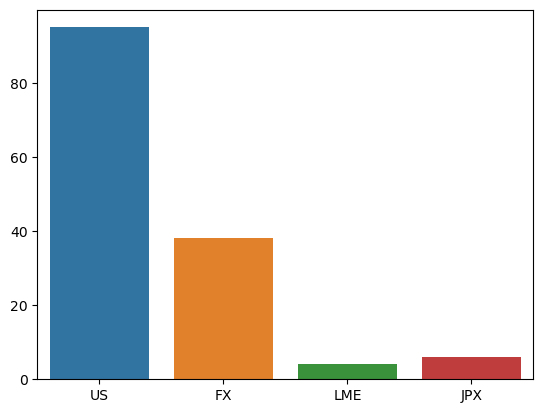

In [15]:
sns.barplot(size)
plt.savefig('commodity_distribution.png')

## US Commodity

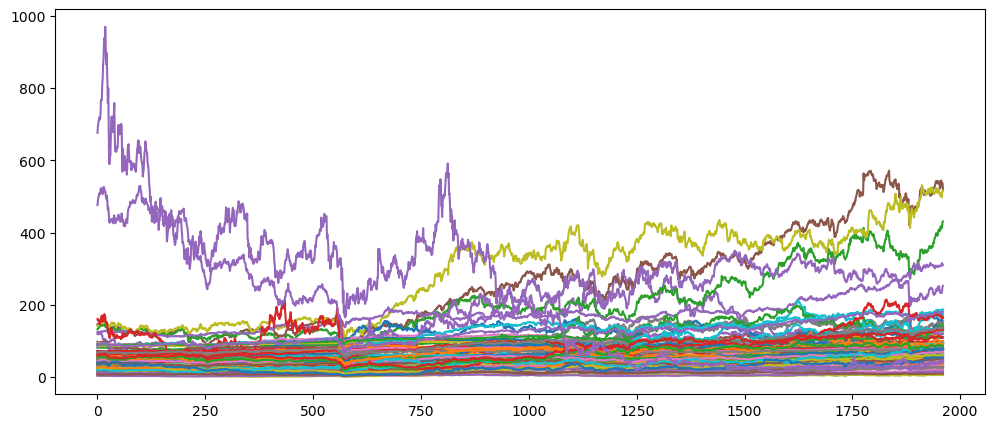

In [28]:
plt.figure(figsize=(12, 5))
for c in US.columns:
    plt.plot(US[c])
plt.savefig('US_commodity.png')
plt.show()

## FX Commodity

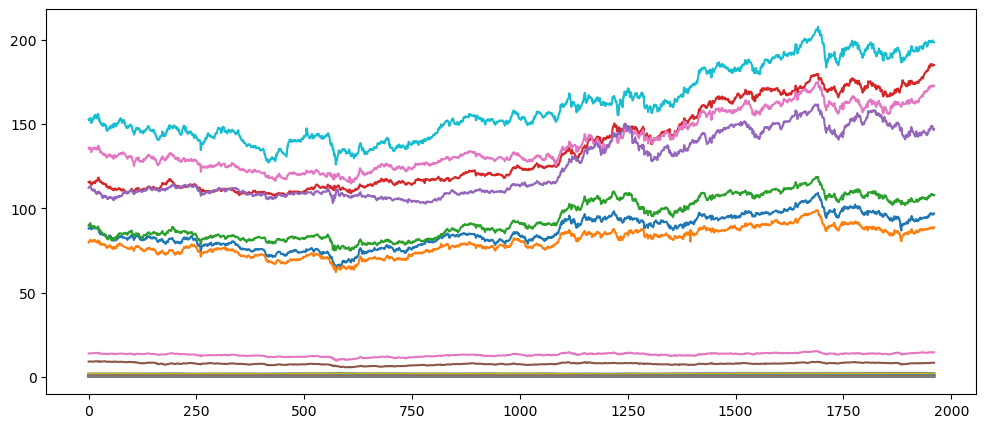

In [29]:
plt.figure(figsize=(12, 5))
for c in FX.columns:
    plt.plot(FX[c])
plt.savefig('FX_commodity.png')
plt.show()

## JPX Commodity

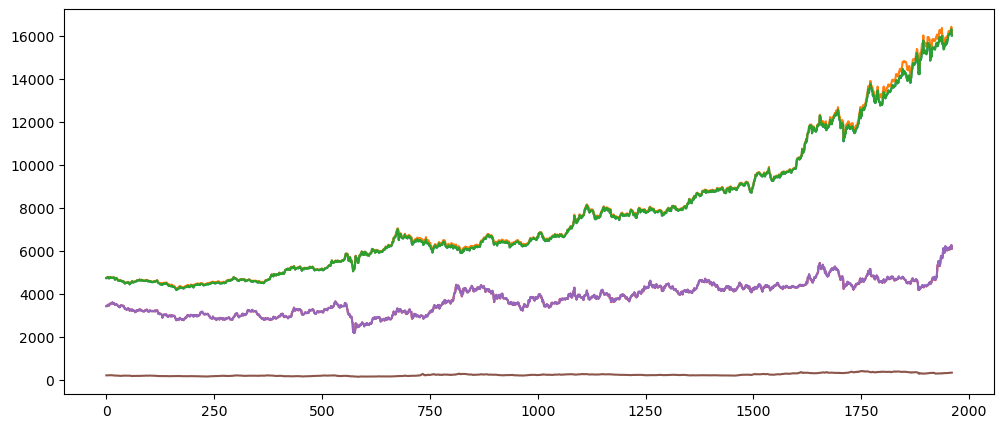

In [30]:
plt.figure(figsize=(12, 5))
for c in JPX.columns:
    plt.plot(JPX[c])
plt.savefig('JPX_commodity.png')
plt.show()

## LME Commodity

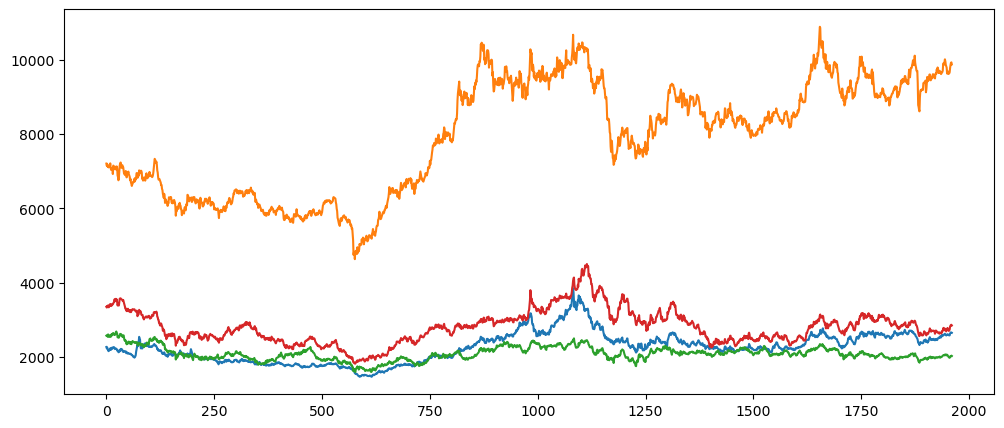

In [31]:
plt.figure(figsize=(12, 5))
for c in LME.columns:
    plt.plot(LME[c])
plt.savefig('LME_commodity.png')
plt.show()

# Making Data Stationary

### We are taking only 'close' values because:
1. Some commodities has only close values
2. Close values matters as they are the final price

### After taking 'close' values we are making it stationary using 2 steps:
1. taking log of all commodities to normalize them (adding 1e-10 a small value in case any value is 0)
2. taking differencial value i.e price[t] - price[t-1]

Note: FX dont have any close/Close term at end so use c.startswith('FX')

In [20]:
stationary = np.log(train[[c for c in train.columns if c.startswith('FX') or c.endswith('lose')]] + 1e-10).diff(1).dropna()

# EDA

## Before vs After making data stationary

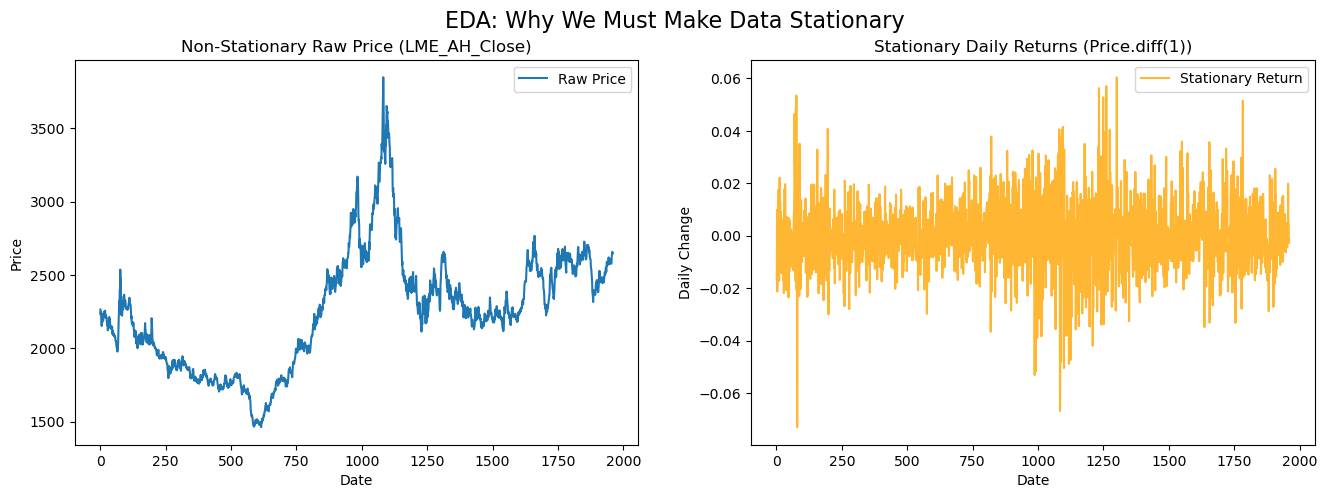

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

ax1.plot(train['LME_AH_Close'], label='Raw Price')
ax1.set_title("Non-Stationary Raw Price (LME_AH_Close)")
ax1.set_xlabel("Date")
ax1.set_ylabel("Price")
ax1.legend()

ax2.plot(stationary['LME_AH_Close'], label='Stationary Return', color='orange', alpha=0.8)
ax2.set_title("Stationary Daily Returns (Price.diff(1))")
ax2.set_xlabel("Date")
ax2.set_ylabel("Daily Change")
ax2.legend()

plt.suptitle("EDA: Why We Must Make Data Stationary", fontsize=16)
plt.savefig('Before_vs_after_stationary_1.png')
plt.show()

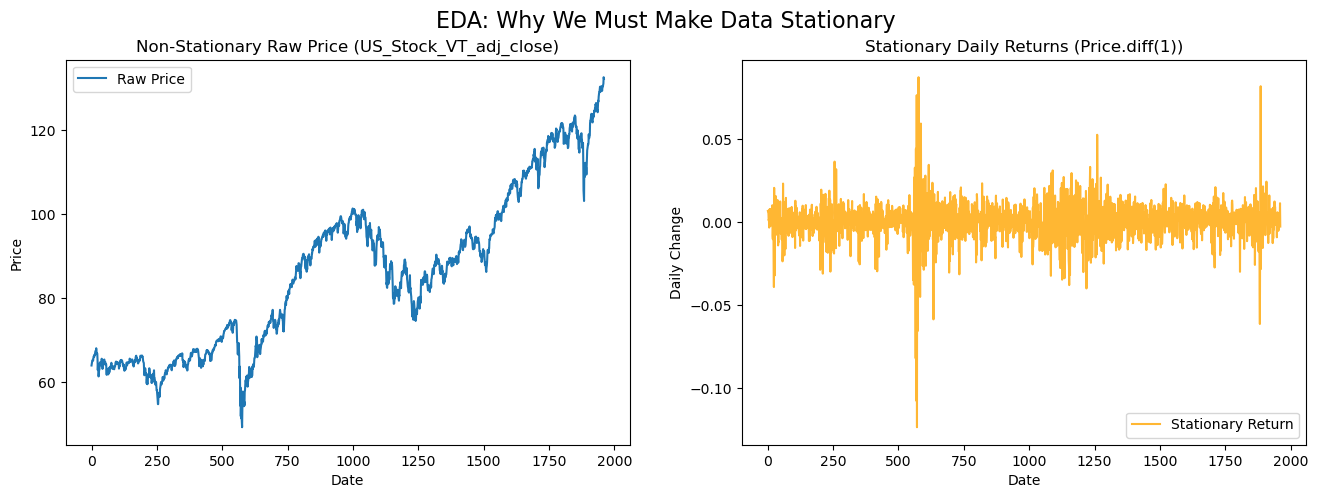

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

ax1.plot(train['US_Stock_VT_adj_close'], label='Raw Price')
ax1.set_title("Non-Stationary Raw Price (US_Stock_VT_adj_close)")
ax1.set_xlabel("Date")
ax1.set_ylabel("Price")
ax1.legend()

ax2.plot(stationary['US_Stock_VT_adj_close'], label='Stationary Return', color='orange', alpha=0.8)
ax2.set_title("Stationary Daily Returns (Price.diff(1))")
ax2.set_xlabel("Date")
ax2.set_ylabel("Daily Change")
ax2.legend()

plt.suptitle("EDA: Why We Must Make Data Stationary", fontsize=16)
plt.savefig('Before_vs_after_stationary_2.png')
plt.show()

# Using ACF (Autocorrelation Function) and PACF (Partial Autocorrelation Function)

## Gives us which lag values are useful for each commodities

In [34]:
threshold = 0.02 
max_lag = 4
lag_vectors = {}

for c in stationary.columns:
    s = stationary[c]

    acf_series = acf(s, nlags=max_lag, fft=False)
    pacf_series = pacf(s, nlags=max_lag, method="ywm")

    sig_lags_acf = [i for i, val in enumerate(acf_series[1:], start=1) if abs(val) > threshold]
    sig_lags_pacf = [i for i, val in enumerate(pacf_series[1:], start=1) if abs(val) > threshold]

    combined_sig = sorted(set(sig_lags_acf + sig_lags_pacf))

    lag_vector = [1 if i in combined_sig else 0 for i in range(1, max_lag + 1)]

    lag_vectors[c] = lag_vector

lag_matrix = pd.DataFrame(lag_vectors).T
lag_matrix.columns = [f"lag_{i}" for i in range(1, max_lag + 1)]

In [35]:
print("Lag matrix shape:", lag_matrix.shape)
lag_matrix.head(424)

Lag matrix shape: (143, 4)


,lag_1,lag_2,lag_3,lag_4
LME_AH_Close,1,0,1,1
LME_CA_Close,1,0,1,0
LME_PB_Close,0,1,1,0
LME_ZS_Close,0,0,0,1
JPX_Gold_Mini_Futures_Close,0,1,0,1
...,...,...,...,...
FX_NOKGBP,1,0,1,1
FX_NOKCHF,1,1,0,1
FX_ZARCHF,1,0,0,1
FX_NOKJPY,1,1,1,0


#### ⭐Example: What ACF and PACF gives

In [36]:
c = stationary.columns[1]
s = stationary[c]

print("ACF:", acf(s, nlags=4, fft=False))
print("PACF:", pacf(s, nlags=4, method="ywm"))

ACF: [ 1.         -0.02261084 -0.01606438  0.0250744  -0.00304802]
PACF: [ 1.         -0.02261084 -0.01658411  0.02434931 -0.00219167]


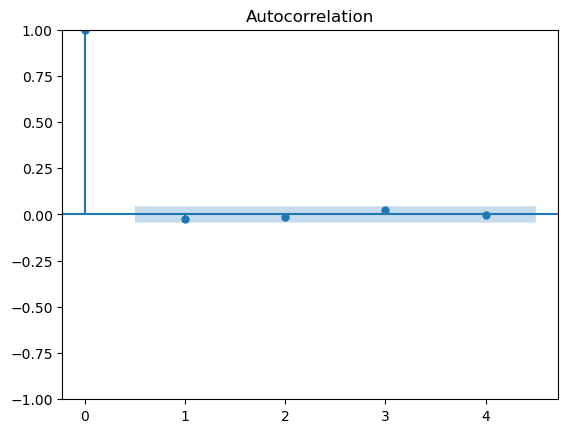

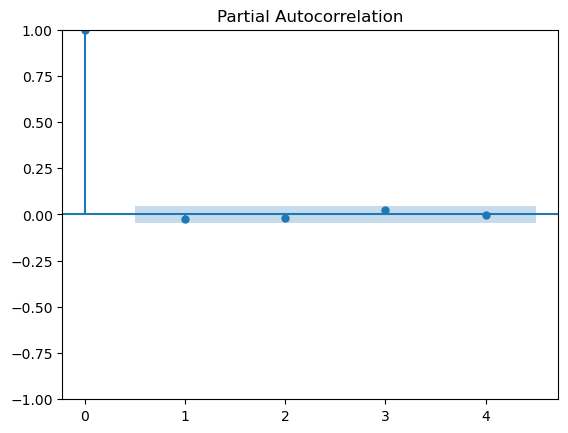

In [38]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(s, lags=4)
plt.savefig('ACF_plot_example.png')
plt.show()

plot_pacf(s, lags=4)
plt.savefig('PACF_plot_example.png')
plt.show()

# Cluster Based on the ACF and PACF vectors

In [39]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(lag_matrix)

inertia = []
scores = {}

for k in range(2, 8):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X_scaled)  
    
    inertia.append(kmeans.inertia_)
    scores[k] = silhouette_score(X_scaled, cluster_labels)
    

best_k = max(scores, key=scores.get)
print("Best number of clusters:", best_k)

kmeans_final = KMeans(n_clusters=best_k, random_state=42, n_init=10)
final_cluster_labels = kmeans_final.fit_predict(X_scaled)

lag_matrix['Cluster'] = final_cluster_labels

for c in sorted(lag_matrix['Cluster'].unique()):
    members = lag_matrix[lag_matrix['Cluster'] == c].index.tolist()
    print(f"Cluster {c}: {members}")

Best number of clusters: 7
Cluster 0: ['JPX_RSS3_Rubber_Futures_Close', 'US_Stock_BCS_adj_close', 'US_Stock_BP_adj_close', 'US_Stock_BSV_adj_close', 'US_Stock_COP_adj_close', 'US_Stock_EEM_adj_close', 'US_Stock_EFA_adj_close', 'US_Stock_EWJ_adj_close', 'US_Stock_FCX_adj_close', 'US_Stock_FXI_adj_close', 'US_Stock_HAL_adj_close', 'US_Stock_IEMG_adj_close', 'US_Stock_RY_adj_close', 'US_Stock_SHEL_adj_close', 'US_Stock_STLD_adj_close', 'US_Stock_VGK_adj_close', 'US_Stock_VWO_adj_close', 'US_Stock_XLE_adj_close', 'FX_GBPJPY', 'FX_CADUSD']
Cluster 1: ['LME_PB_Close', 'JPX_Gold_Mini_Futures_Close', 'JPX_Gold_Rolling-Spot_Futures_Close', 'JPX_Gold_Standard_Futures_Close', 'JPX_Platinum_Mini_Futures_Close', 'JPX_Platinum_Standard_Futures_Close', 'US_Stock_AEM_adj_close', 'US_Stock_BKR_adj_close', 'US_Stock_BND_adj_close', 'US_Stock_EMB_adj_close', 'US_Stock_EOG_adj_close', 'US_Stock_FNV_adj_close', 'US_Stock_GDXJ_adj_close', 'US_Stock_GLD_adj_close', 'US_Stock_IAU_adj_close', 'US_Stock_IEF_adj

In [40]:
for c in sorted(lag_matrix['Cluster'].unique()):
    members = lag_matrix[lag_matrix['Cluster'] == c].index.tolist()
    print(f"Cluster {c}: contains {len(members)} assets")

Cluster 0: contains 20 assets
Cluster 1: contains 28 assets
Cluster 2: contains 20 assets
Cluster 3: contains 25 assets
Cluster 4: contains 17 assets
Cluster 5: contains 18 assets
Cluster 6: contains 15 assets


# Clustering EDA

## 1. Number of Commodities per cluster

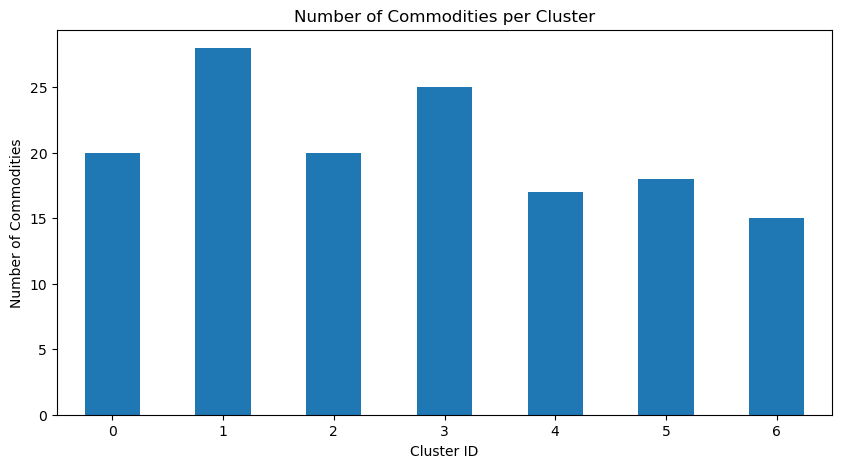

In [41]:
lag_matrix['Cluster'].value_counts().sort_index().plot(
    kind='bar',
    figsize=(10, 5),
    title='Number of Commodities per Cluster'
)
plt.xlabel("Cluster ID")
plt.ylabel("Number of Commodities")
plt.xticks(rotation=0)
plt.savefig('commodities_per_cluster.png')
plt.show()

## 2. Elbow plot

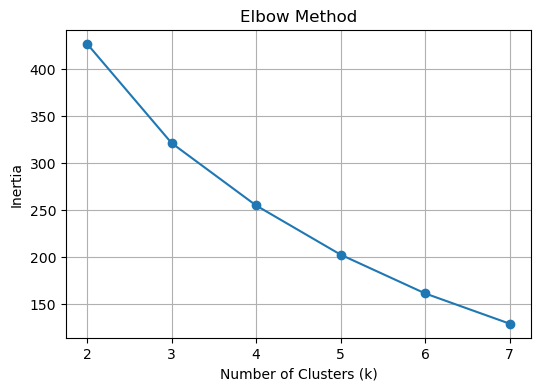

In [43]:
plt.figure(figsize=(6, 4))
plt.plot(range(2, 8), inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.grid(True)
plt.savefig('elbow_plot.png')
plt.show()

## 3. Silhouette Score Plot

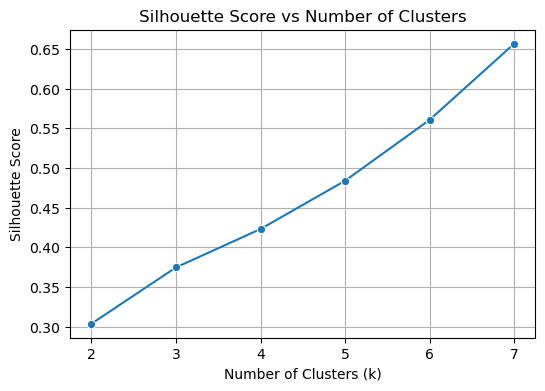

In [44]:
plt.figure(figsize=(6, 4))
sns.lineplot(x=list(scores.keys()), y=list(scores.values()), marker='o')
plt.title('Silhouette Score vs Number of Clusters')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.savefig('silhouette_Score.png')
plt.show()

## 4. 2D PCA Scatter Plot

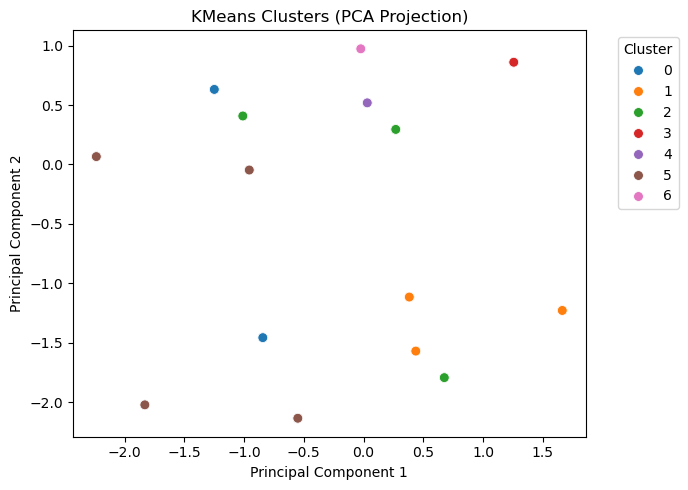

In [50]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
pca_df['Cluster'] = final_cluster_labels

plt.figure(figsize=(7, 5))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Cluster', palette='tab10', s=50)
plt.title('KMeans Clusters (PCA Projection)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('pca_scatter.png')
plt.show()

## Map each target to cluster given in target_pairs.csv

In [51]:
target_to_cluster = {}
for _, row in pairs.iterrows():
    pair_formula = row['pair']                   
    primary_asset = pair_formula.split(' - ')[0].strip()
    target_name = row['target']
    target_to_cluster[target_name] = int(lag_matrix.loc[primary_asset, 'Cluster'])

target_cluster_map = (
    pd.Series(target_to_cluster)
      .to_frame('Cluster')
      .reset_index()
      .rename(columns={'index': 'Target'})
)
target_cluster_map.head()

,Target,Cluster
0,target_0,4
1,target_1,1
2,target_2,2
3,target_3,2
4,target_4,2


# Training each Cluster's Model

In [52]:
target_lags = [1, 2]
train_ratio = 0.8
n_iter_search = 5 
final_results = []

In [53]:
unique_clusters = target_cluster_map['Cluster'].nunique()

print(f"\n--- Training {unique_clusters} XGBoost Multi-Output Models ---\n")

for cluster_id in sorted(target_cluster_map['Cluster'].unique()):

    cluster_targets = target_cluster_map[target_cluster_map['Cluster'] == cluster_id]['Target'].tolist()

    # Getting commodities from each target
    assets_in_targets = set()
    for t_name in cluster_targets:
        row = pairs[pairs['target'] == t_name]
        if not row.empty:
            assets = row['pair'].iloc[0].split(" - ")
            for a in assets:
                assets_in_targets.add(a.strip())

    cluster_assets = [a for a in assets_in_targets if a in stationary.columns]

    # Feature Engineering
    X = stationary[cluster_assets].copy()
 
    for asset in cluster_assets:
        for lag in range(1, max_lag + 1):
            X[f"{asset}_lag{lag}"] = X[asset].shift(lag)

    # Drop raw series (keep only lagged features)
    X = X.drop(columns=cluster_assets, errors="ignore")
    X = X.replace([np.inf, -np.inf], np.nan).fillna(0)

    y_full = labels[cluster_targets]

    # Add lagged targets as features
    y_lag_features = pd.DataFrame(index=y_full.index)

    for lag in target_lags:
        temp = y_full.shift(lag).add_suffix(f"_lag{lag}")
        y_lag_features = y_lag_features.join(temp, how='left')

    X = X.join(y_lag_features, how='left').fillna(0)

    # Target
    y = y_full.shift(-1)

    # Align X and Y
    X_aligned, y_aligned = X.align(y, join='inner', axis=0)
    X_aligned = X_aligned.iloc[:-1]
    y_aligned = y_aligned.iloc[:-1]

    # Train-test split
    split = int(len(X_aligned) * train_ratio)
    X_train, X_test = X_aligned.iloc[:split], X_aligned.iloc[split:]
    y_train, y_test = y_aligned.iloc[:split], y_aligned.iloc[split:]

    # Scale features
    scaler_X = StandardScaler()
    X_train_scaled = scaler_X.fit_transform(X_train)
    X_test_scaled = scaler_X.transform(X_test)

    # XGBoost
    base_xgb = xgb.XGBRegressor(
        objective="reg:squarederror",
        n_estimators=100,
        max_depth=6,
        learning_rate=0.05,
        n_jobs=-1,
        subsample=0.9,
        colsample_bytree=0.9,
        random_state=42
    )

    model = MultiOutputRegressor(base_xgb)

    # Hyperparameter 
    param_dist = {
        "estimator__max_depth": randint(3, 8),
        "estimator__learning_rate": [0.03, 0.05, 0.1],
        "estimator__subsample": [0.8, 0.9, 1.0]
    }

    random_search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_dist,
        n_iter=n_iter_search,
        scoring="r2",
        cv=TimeSeriesSplit(n_splits=3),
        n_jobs=-1,
        random_state=42
    )

    random_search.fit(X_train_scaled, y_train)
    best_model = random_search.best_estimator_

    # Predict
    y_pred = best_model.predict(X_test_scaled)

    # Store results
    for i, target_name in enumerate(cluster_targets):
        actual = y_test.iloc[:, i]
        predicted = y_pred[:, i]

        rmse = np.sqrt(mean_squared_error(actual, predicted))
        r2 = r2_score(actual, predicted)

        final_results.append([target_name, cluster_id, rmse, r2])

    # print(f'Model for cluster {cluster_id} trained')
    print(f'Cluster {cluster_id} completed with {len(cluster_targets)} targets\n')


--- Training 7 XGBoost Multi-Output Models ---

Model for cluster 0 trained
Model for cluster 1 trained
Model for cluster 2 trained
Model for cluster 3 trained
Model for cluster 4 trained
Model for cluster 5 trained
Model for cluster 6 trained


In [54]:
# Saving results
results_df = pd.DataFrame(final_results, columns=["Target", "Cluster_ID", "RMSE", "R2"])
results_df = results_df.dropna(subset=["R2"])

print("\n### TOP 10 BY R² ###")
print(results_df.sort_values(by="R2", ascending=False).head(10))

print("\n### WORST 10 BY R² ###")
print(results_df.sort_values(by="R2", ascending=True).head(10))

print(f"\n💡 Average R² across all targets = {results_df['R2'].mean():.4f}")


### TOP 10 BY R² ###
         Target  Cluster_ID      RMSE        R2
206  target_188           2  0.005495  0.903469
360  target_196           5  0.005892  0.897495
84   target_177           1  0.005073  0.894982
344  target_102           5  0.005218  0.867702
211  target_201           2  0.010495  0.865261
201  target_164           2  0.006627  0.850222
352  target_139           5  0.012865  0.847617
187  target_100           2  0.008430  0.843820
348  target_124           5  0.010746  0.839743
409  target_195           6  0.017899  0.839512

### WORST 10 BY R² ###
         Target  Cluster_ID      RMSE        R2
245  target_335           2  0.044257 -0.256028
265  target_411           2  0.048159 -0.230624
140  target_352           1  0.038179 -0.067800
258  target_396           2  0.036347 -0.021167
197  target_151           2  0.020843 -0.008149
406  target_152           6  0.018457  0.006007
221  target_241           2  0.050685  0.021433
405  target_132           6  0.023422  0.0

In [75]:
# saving model 

import pickle

target_lags = [1, 2]
train_ratio = 0.8
n_iter_search = 5 
final_results = []

# Dictionary
saved_data = {
    'models': {},           # Trained models per cluster
    'scalers': {},          # Scalers per cluster
    'test_data': {},        # X_test and y_test per cluster
    'cluster_info': {}      # Features and targets per cluster
}

unique_clusters = target_cluster_map['Cluster'].nunique()
print(f"\n--- Training {unique_clusters} XGBoost Multi-Output Models ---\n")

for cluster_id in sorted(target_cluster_map['Cluster'].unique()):
    cluster_targets = target_cluster_map[target_cluster_map['Cluster'] == cluster_id]['Target'].tolist()
    
    saved_data['models'][cluster_id] = best_model
    saved_data['scalers'][cluster_id] = scaler_X
    saved_data['test_data'][cluster_id] = {
        'X_test': X_test,
        'y_test': y_test,
        'X_test_scaled': X_test_scaled,
        'y_pred': y_pred,
        'target_names': cluster_targets
    }
    saved_data['cluster_info'][cluster_id] = {
        'targets': cluster_targets,
        'assets': cluster_assets
    }
    
    print(f'Model for cluster {cluster_id} trained and saved')

# Save everything to disk
print("\n💾 Saving all models and data...")
with open('trained_models_complete.pkl', 'wb') as f:
    pickle.dump(saved_data, f)

with open('final_results.pkl', 'wb') as f:
    pickle.dump(final_results, f)

print("✓ All models saved to 'trained_models_complete.pkl'")
print("✓ Results saved to 'final_results.pkl'")


# ======================================================
# PART 2: LOAD AND PLOT ANY TARGET (RUN THIS ANYTIME)
# ======================================================

def plot_target_predictions(target_name, saved_models_path='trained_models_complete.pkl'):
    
    # Load saved data
    print(f"\n📂 Loading saved models from {saved_models_path}...")
    with open(saved_models_path, 'rb') as f:
        saved_data = pickle.load(f)
    
    
    cluster_id = None
    target_index = None
    
    for cid, info in saved_data['cluster_info'].items():
        if target_name in info['targets']:
            cluster_id = cid
            target_index = info['targets'].index(target_name)
            break
    
    if cluster_id is None:
        print(f"❌ Target '{target_name}' not found in saved models!")
        print(f"Available targets: {[t for info in saved_data['cluster_info'].values() for t in info['targets']]}")
        return
    
    print(f"✓ Found target '{target_name}' in Cluster {cluster_id}")
    
    # Get test data and predictions
    test_data = saved_data['test_data'][cluster_id]
    y_test = test_data['y_test'].iloc[:, target_index]
    y_pred = test_data['y_pred'][:, target_index]
    
    # metrics calculation
    from sklearn.metrics import r2_score, mean_squared_error
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    #plotting
    plt.figure(figsize=(14, 6))
    
    plt.plot(range(len(y_test)), y_test.values, 
             label="Actual", linewidth=2.5, color='black', alpha=0.8, linestyle='-')
    
    plt.plot(range(len(y_pred)), y_pred, 
             label="Predicted (XGBoost)", linewidth=2.5, color='red', alpha=0.9, linestyle='-')
    
    plt.title(f"Actual vs Predicted: {target_name}\nR² = {r2:.4f} | RMSE = {rmse:.4f}", 
              fontsize=15, fontweight='bold', pad=15)
    plt.xlabel("Time Index (Test Period)", fontsize=12)
    plt.ylabel("Value", fontsize=12)
    plt.legend(loc='best', fontsize=11, framealpha=0.9)
    plt.grid(True, alpha=0.3, linestyle='--')
    plt.tight_layout()
    
    # Save
    filename = f"actual_vs_predicted_{target_name.replace(' ', '_').replace('/', '_')}.png"
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    print(f"✓ Saved: {filename}")
    
    plt.show()
    
    return r2, rmse


--- Training 7 XGBoost Multi-Output Models ---

Model for cluster 0 trained and saved
Model for cluster 1 trained and saved
Model for cluster 2 trained and saved
Model for cluster 3 trained and saved
Model for cluster 4 trained and saved
Model for cluster 5 trained and saved
Model for cluster 6 trained and saved

💾 Saving all models and data...
✓ All models saved to 'trained_models_complete.pkl'
✓ Results saved to 'final_results.pkl'



📂 Loading saved models from trained_models_complete.pkl...
✓ Found target 'target_20' in Cluster 5
✓ Saved: actual_vs_predicted_target_20.png


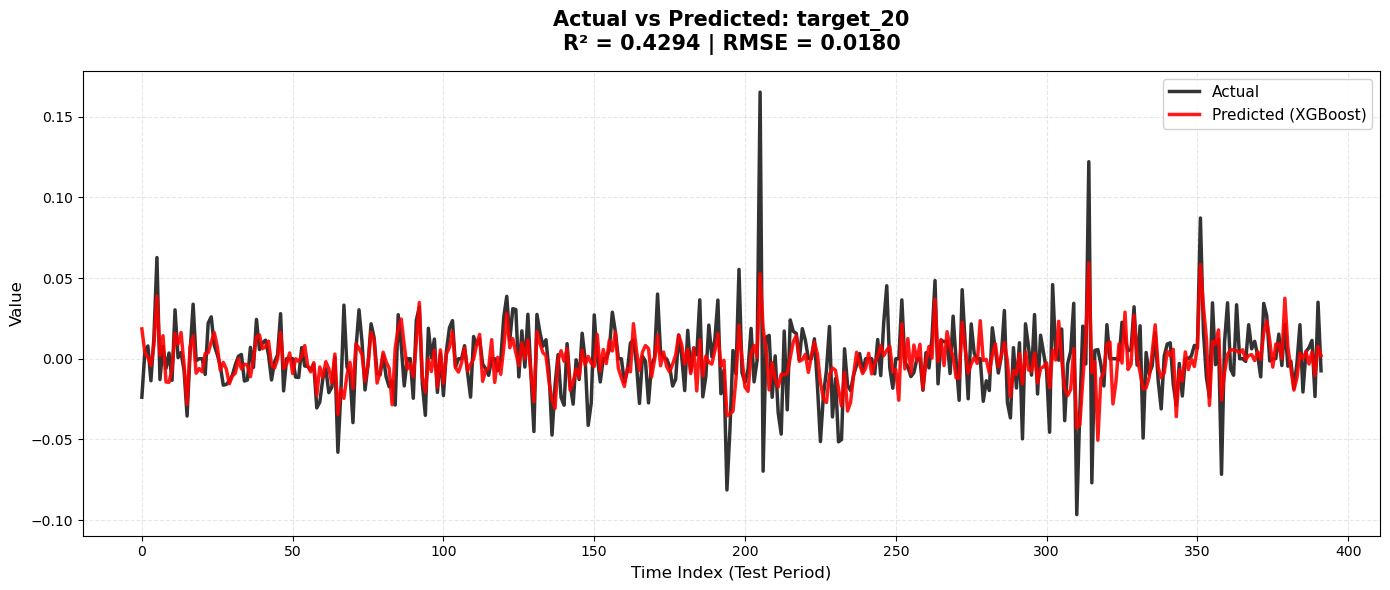


📂 Loading saved models from trained_models_complete.pkl...
✓ Found target 'target_334' in Cluster 0
✓ Saved: actual_vs_predicted_target_334.png


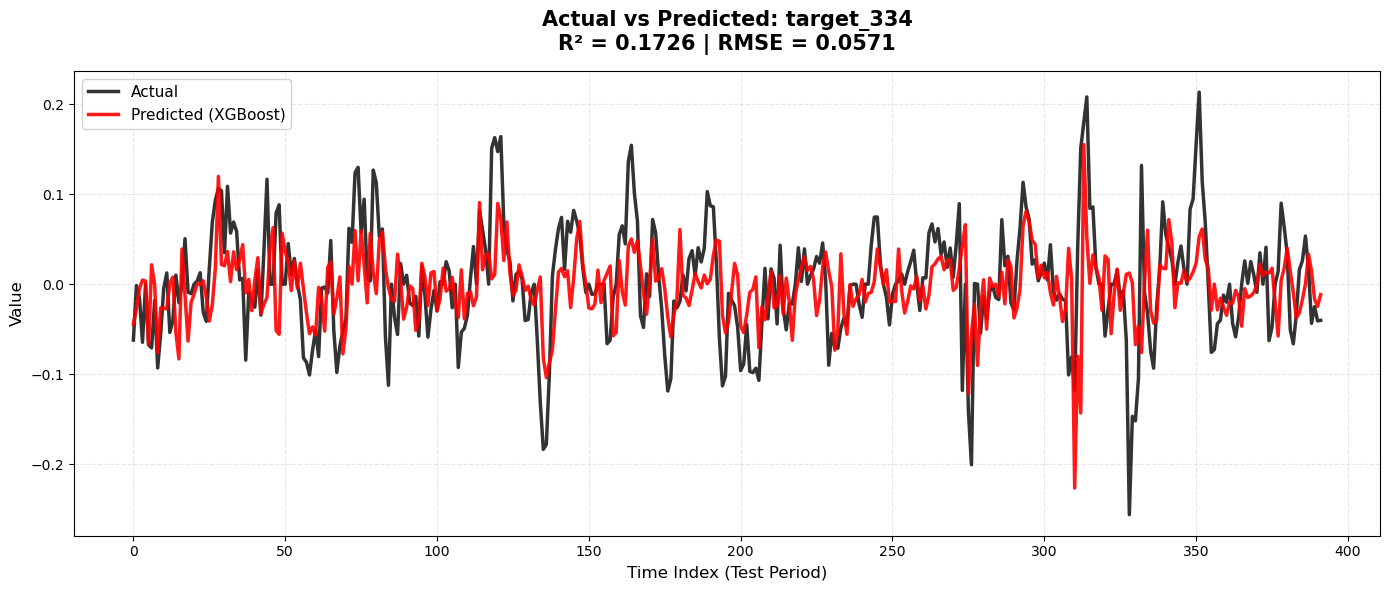


📂 Loading saved models from trained_models_complete.pkl...
✓ Found target 'target_10' in Cluster 1
✓ Saved: actual_vs_predicted_target_10.png


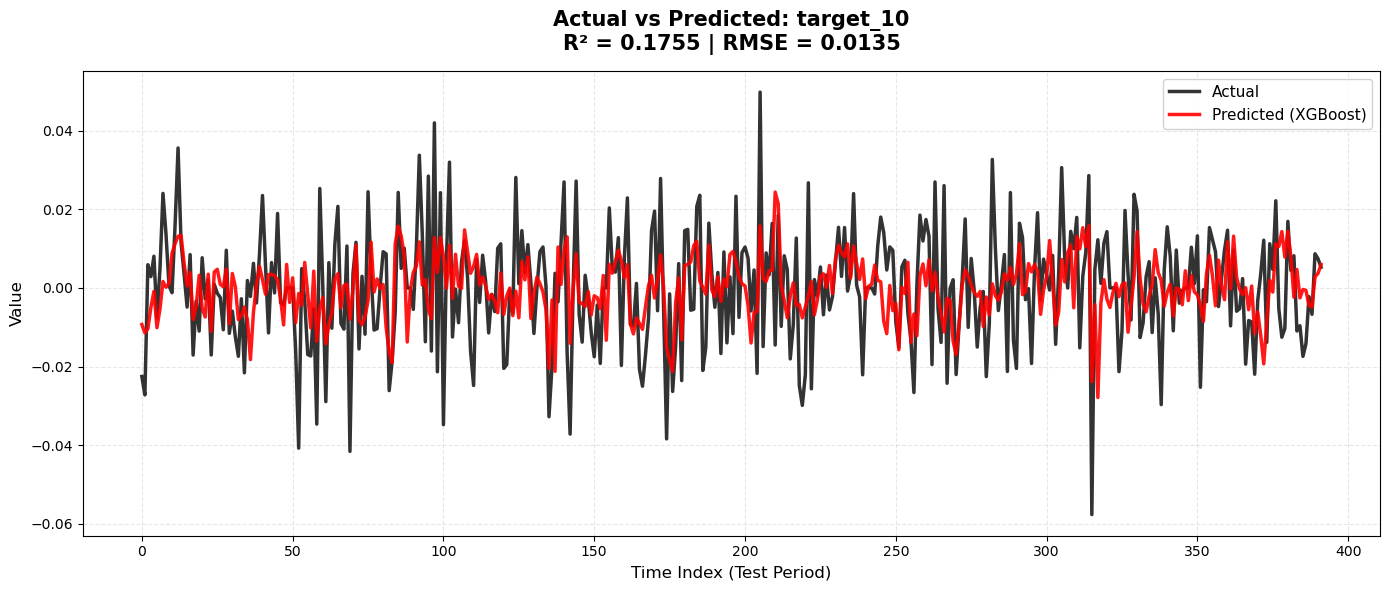

In [76]:
for target in ['target_20', 'target_334', 'target_10']:
    plot_target_predictions(target)


BASELINE MODELS COMPARISON

Available targets in cluster map: 424
Evaluating 3 targets: ['target_0', 'target_1', 'target_2']

Target: target_0

Training models...
Linear Regression         -> R² = -0.1203, RMSE = 0.0100
Ridge Regression          -> R² = -0.0934, RMSE = 0.0099
Decision Tree             -> R² = -0.0026, RMSE = 0.0095
Random Forest             -> R² = -0.0289, RMSE = 0.0096
XGBoost (Our Model)       -> R² = 0.2320, RMSE = 0.0083


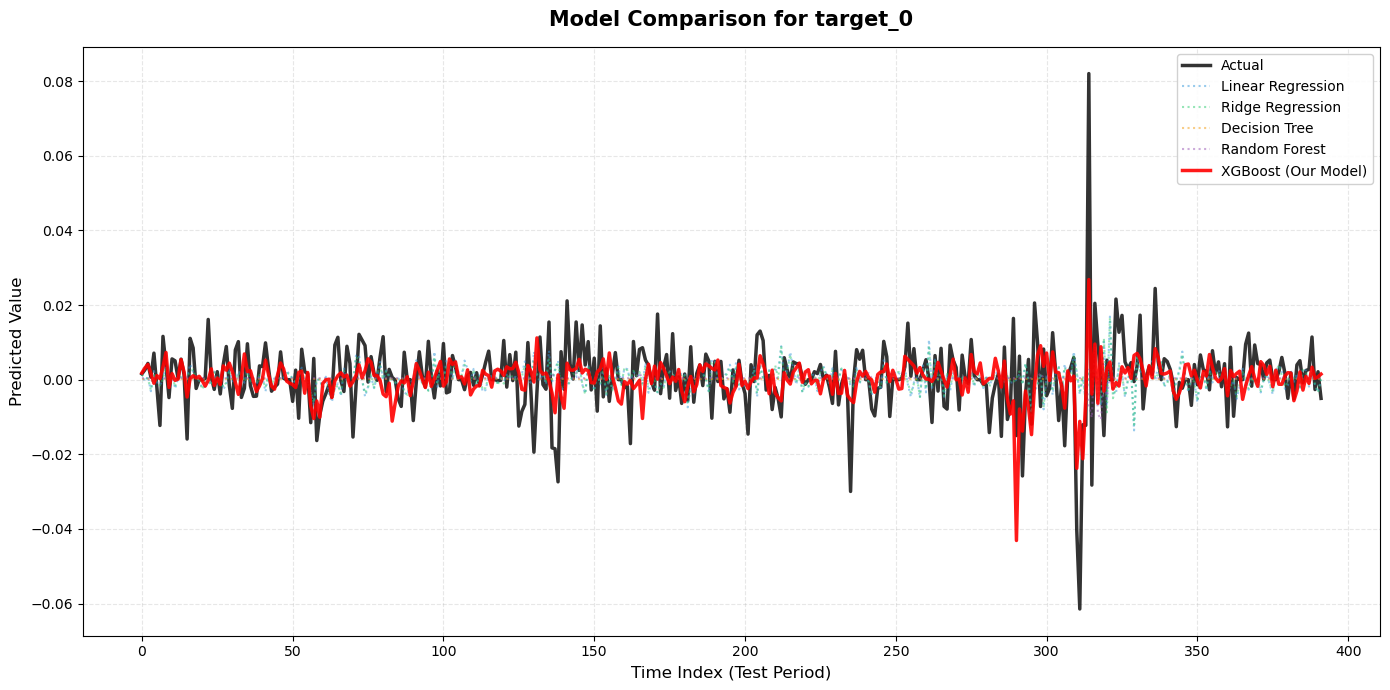


Target: target_1

Training models...
Linear Regression         -> R² = -0.5028, RMSE = 0.0158
Ridge Regression          -> R² = -0.2157, RMSE = 0.0142
Decision Tree             -> R² = -0.0019, RMSE = 0.0129
Random Forest             -> R² = -0.0471, RMSE = 0.0132
XGBoost (Our Model)       -> R² = 0.5347, RMSE = 0.0088


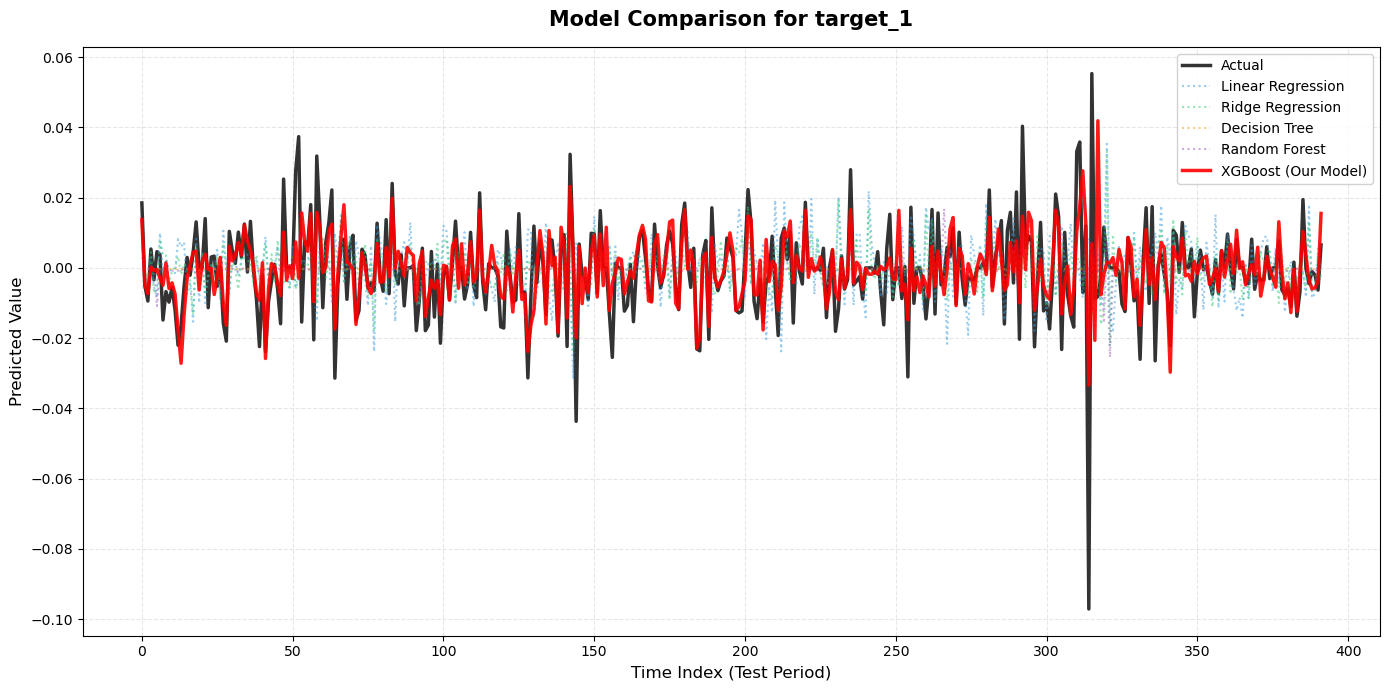


Target: target_2

Training models...
Linear Regression         -> R² = -0.2844, RMSE = 0.0132
Ridge Regression          -> R² = -0.1276, RMSE = 0.0123
Decision Tree             -> R² = -0.0491, RMSE = 0.0119
Random Forest             -> R² = -0.0267, RMSE = 0.0118
XGBoost (Our Model)       -> R² = 0.2695, RMSE = 0.0099


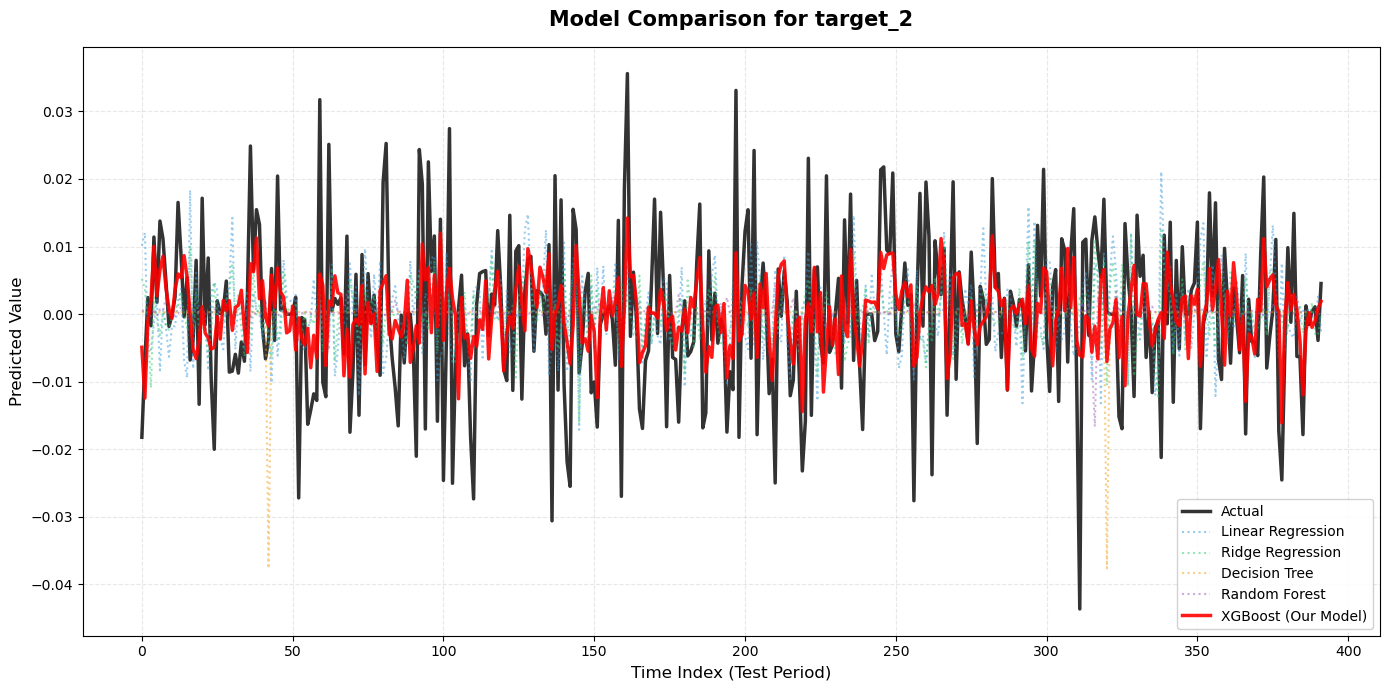


SUMMARY: ALL MODELS & TARGETS

R² Scores by Model and Target:
Target               target_0  target_1  target_2
Model                                            
Decision Tree       -0.002560 -0.001864 -0.049060
Linear Regression   -0.120274 -0.502816 -0.284415
Random Forest       -0.028879 -0.047113 -0.026735
Ridge Regression    -0.093368 -0.215658 -0.127616
XGBoost (Our Model)  0.231988  0.534682  0.269494

------------------------------------------------------------
Average R² Across All Targets:
XGBoost (Our Model)       -> Avg R² = 0.3454
Decision Tree             -> Avg R² = -0.0178
Random Forest             -> Avg R² = -0.0342
Ridge Regression          -> Avg R² = -0.1455
Linear Regression         -> Avg R² = -0.3025

Comparison Complete!


In [77]:
# ======================================================
# BASELINE MODELS COMPARISON
# ======================================================
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt

print("\n" + "="*60)
print("BASELINE MODELS COMPARISON")
print("="*60)

# ------------------------------------------------------
# Select 2-3 targets for comparison
# ------------------------------------------------------

available_targets = target_cluster_map['Target'].unique().tolist()
selected_targets = available_targets[:min(3, len(available_targets))]
print(f"\nAvailable targets in cluster map: {len(available_targets)}")
print(f"Evaluating {len(selected_targets)} targets: {selected_targets}")


all_results = []

# ------------------------------------------------------
# Loop through targets
# ------------------------------------------------------
for target_idx, target_name in enumerate(selected_targets):
    print(f"\n{'='*60}")
    print(f"Target: {target_name}")
    print(f"{'='*60}")
    
    target_row = target_cluster_map[target_cluster_map['Target'] == target_name]
    
    if target_row.empty:
        print(f"Warning: {target_name} not found in target_cluster_map, skipping...")
        continue
        
    cluster_id = target_row['Cluster'].iloc[0]
    cluster_targets = target_cluster_map[target_cluster_map['Cluster'] == cluster_id]['Target'].tolist()
    
    assets_in_targets = set()
    cluster_mask = pairs['target'].isin(cluster_targets)
    cluster_pairs = pairs[cluster_mask]['pair'].values
    
    for pair_str in cluster_pairs:
        assets = pair_str.split(" - ")
        assets_in_targets.update(a.strip() for a in assets)
    
    cluster_assets = list(assets_in_targets & set(stationary.columns))
    
    # ------------------------------------------------------
    # Feature Engineering
    # ------------------------------------------------------
    X = stationary[cluster_assets].copy()
    
    
    lagged_data = {}
    for asset in cluster_assets:
        asset_col = X[asset].values
        for lag in range(1, max_lag + 1):
            lagged_data[f"{asset}_lag{lag}"] = np.roll(asset_col, lag)
            lagged_data[f"{asset}_lag{lag}"][:lag] = np.nan
    
    X_base = pd.DataFrame(lagged_data, index=X.index)
    X_base = X_base.replace([np.inf, -np.inf], np.nan).fillna(0)
    
   
    y = labels[target_name].shift(-1)
    
   
    y_full = labels[cluster_targets]
    lagged_targets = []
    for lag in target_lags:
        lagged_targets.append(y_full.shift(lag).add_suffix(f"_lag{lag}"))
    
    if lagged_targets:
        y_lag_features = pd.concat(lagged_targets, axis=1)
        X_xgboost = X_base.join(y_lag_features, how='left').fillna(0)
    else:
        X_xgboost = X_base.copy()
    
    
    common_idx = X_base.index.intersection(y.index)
    X_base_aligned = X_base.loc[common_idx].iloc[:-1]
    X_xgboost_aligned = X_xgboost.loc[common_idx].iloc[:-1]
    y_aligned = y.loc[common_idx].iloc[:-1]
    
    # ------------------------------------------------------
    # Train-test split
    # ------------------------------------------------------
    split = int(len(X_base_aligned) * train_ratio)
    
    
    X_base_train = X_base_aligned.iloc[:split]
    X_base_test = X_base_aligned.iloc[split:]
    
  
    X_xgb_train = X_xgboost_aligned.iloc[:split]
    X_xgb_test = X_xgboost_aligned.iloc[split:]
    
    y_train = y_aligned.iloc[:split]
    y_test = y_aligned.iloc[split:]
    
   
    scaler_base = StandardScaler()
    X_base_train_scaled = scaler_base.fit_transform(X_base_train)
    X_base_test_scaled = scaler_base.transform(X_base_test)
    
    scaler_xgb = StandardScaler()
    X_xgb_train_scaled = scaler_xgb.fit_transform(X_xgb_train)
    X_xgb_test_scaled = scaler_xgb.transform(X_xgb_test)
    
    # ------------------------------------------------------
    # Define Baseline Models
    # ------------------------------------------------------
    models = {
        "Linear Regression": LinearRegression(),
        "Ridge Regression": Ridge(alpha=100),
        "Decision Tree": DecisionTreeRegressor(max_depth=2, min_samples_split=20, random_state=42),
        "Random Forest": RandomForestRegressor(n_estimators=10, max_depth=2, min_samples_split=20, random_state=42, n_jobs=-1),
        "XGBoost (Our Model)": xgb.XGBRegressor(
            objective="reg:squarederror",
            n_estimators=300, 
            max_depth=10,  
            learning_rate=0.1,  
            n_jobs=-1,
            subsample=0.95,
            colsample_bytree=0.95,
            random_state=42,
            tree_method='hist',
            min_child_weight=1,
            gamma=0,
            reg_alpha=0,
            reg_lambda=0.5
        )
    }
    
    baseline_preds = {}
    
    # ------------------------------------------------------
    # Train and Predict
    # ------------------------------------------------------
    print("\nTraining models...")
    for name, model in models.items():
        if name == "XGBoost (Our Model)":
            model.fit(X_xgb_train_scaled, y_train)
            preds = model.predict(X_xgb_test_scaled)
        else: 
            model.fit(X_base_train_scaled, y_train)
            preds = model.predict(X_base_test_scaled)
        
        baseline_preds[name] = preds
        
        # Calculate metrics
        r2 = r2_score(y_test, preds)
        rmse = np.sqrt(mean_squared_error(y_test, preds))
        
        all_results.append({
            'Target': target_name,
            'Model': name,
            'R²': r2,
            'RMSE': rmse
        })
        
        print(f"{name:25s} -> R² = {r2:.4f}, RMSE = {rmse:.4f}")
    
    # ------------------------------------------------------
    # Plot Comparison
    # ------------------------------------------------------
    plt.figure(figsize=(14, 7))
    
    # Plot actual values (solid black line)
    plt.plot(range(len(y_test)), y_test.values, 
             label="Actual", linewidth=2.5, color='black', alpha=0.8, linestyle='-')
    
    colors = ['#3498db', '#2ecc71', '#f39c12', '#9b59b6']  # Blue, green, orange, purple
    for i, (name, preds) in enumerate(baseline_preds.items()):
        if name != "XGBoost (Our Model)":
            plt.plot(range(len(preds)), preds, 
                    label=name, alpha=0.5, linewidth=1.5, 
                    color=colors[i % len(colors)], linestyle=':', marker='')
    
    plt.plot(range(len(baseline_preds["XGBoost (Our Model)"])), 
             baseline_preds["XGBoost (Our Model)"], 
             label="XGBoost (Our Model)", linewidth=2.5, color='red', alpha=0.9, linestyle='-')
    
    plt.title(f"Model Comparison for {target_name}", fontsize=15, fontweight='bold', pad=15)
    plt.xlabel("Time Index (Test Period)", fontsize=12)
    plt.ylabel("Predicted Value", fontsize=12)
    plt.legend(loc='best', fontsize=10, framealpha=0.9)
    plt.grid(True, alpha=0.3, linestyle='--')
    plt.tight_layout()
    plt.savefig('actual_vs_predicted')
    plt.show()

# ------------------------------------------------------
# Summary Table
# ------------------------------------------------------
print("\n" + "="*60)
print("SUMMARY: ALL MODELS & TARGETS")
print("="*60)

results_df = pd.DataFrame(all_results)
summary_pivot = results_df.pivot_table(
    index='Model', 
    columns='Target', 
    values='R²', 
    aggfunc='first'
)

print("\nR² Scores by Model and Target:")
print(summary_pivot.to_string())

# Average R² across all targets
print("\n" + "-"*60)
print("Average R² Across All Targets:")
avg_r2 = results_df.groupby('Model')['R²'].mean().sort_values(ascending=False)
for model, score in avg_r2.items():
    print(f"{model:25s} -> Avg R² = {score:.4f}")

print("\n" + "="*60)
print("Comparison Complete!")
print("="*60)